# RNNs to Transformers
This notebook shows how to create models that translate between languanges

I will slowly build up the complexity of the model:
1. Starting with a seq2seq architecture without attention,
2. Adding in attention,
3. Then using a transformer

In [1]:
from io import open
import unicodedata
import string
import re
import random
import math

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/tarushii/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation
Using the dataset/data prep code in this tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [3]:
!curl https://download.pytorch.org/tutorial/data.zip --output data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2814k  100 2814k    0     0  27.2M      0 --:--:-- --:--:-- --:--:-- 27.2M


In [5]:
!unzip data.zip -d ./

Archive:  data.zip
  inflating: ./data/eng-fra.txt      
   creating: ./data/names/
  inflating: ./data/names/Arabic.txt  
  inflating: ./data/names/Chinese.txt  
  inflating: ./data/names/Czech.txt  
  inflating: ./data/names/Dutch.txt  
  inflating: ./data/names/English.txt  
  inflating: ./data/names/French.txt  
  inflating: ./data/names/German.txt  
  inflating: ./data/names/Greek.txt  
  inflating: ./data/names/Irish.txt  
  inflating: ./data/names/Italian.txt  
  inflating: ./data/names/Japanese.txt  
  inflating: ./data/names/Korean.txt  
  inflating: ./data/names/Polish.txt  
  inflating: ./data/names/Portuguese.txt  
  inflating: ./data/names/Russian.txt  
  inflating: ./data/names/Scottish.txt  
  inflating: ./data/names/Spanish.txt  
  inflating: ./data/names/Vietnamese.txt  


In [2]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS" : 1, "EOS" : 2}
        self.word2count = {}
        self.index2word = {1: "SOS", 2: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            idx = self.n_words+1
            self.word2index[word] = idx
            self.word2count[word] = 1
            self.index2word[idx] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s) # adds a space before puncutation, because there has to be a space between each token.  
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s) # replaces punctuation (e.g. apostrophes) with a space
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


french_lang, english_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis certain de pouvoir faire mieux .', 'i m sure i can do better .']


In [3]:
def convert_to_tensor(lang, sentence):
    sentence = [lang.word2index[word] for word in sentence.split(' ')]
    sentence.append(lang.word2index["EOS"])
    return torch.tensor(sentence, dtype=torch.long)


class SentenceDataset(Dataset):
    def __init__(self, lang1, lang2, pairs):
        self.lang1 = lang1
        self.lang2 = lang2
        self.pairs = []
        for i in range(len(pairs)):
            s1, s2 = pairs[i]
            self.pairs.append([convert_to_tensor(lang1, s1), convert_to_tensor(lang2,s2)])
    def __getitem__(self, idx):
        return self.pairs[idx][0], self.pairs[idx][1]
    def __len__(self):
        return len(self.pairs)

def pad_collate(batch):
    x, y = zip(*batch)
    x_lens = torch.tensor([len(i) for i in x])
    y_lens = torch.tensor([len(i) for i in y])
    x_pad = pad_sequence(x, padding_value=0)
    y_pad = pad_sequence(y, padding_value=0)
    
    # sort 
    x_lens, idx = x_lens.sort(0, descending=True)
    y_lens = y_lens[idx]
    x_pad = x_pad[:, idx]
    y_pad = y_pad[:, idx]
    
    return x_pad, y_pad, x_lens, y_lens

dataset = SentenceDataset(french_lang, english_lang, pairs)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)

In [4]:
pairs[2]

['ca va .', 'i m ok .']

In [5]:
dataset[10]

(tensor([ 7, 12, 22,  6,  2]), tensor([ 3,  4, 13,  5,  2]))

In [4]:
next(iter(data_loader))[0][:, 0] # sentence length x batch_size

tensor([ 7, 12, 15, 16,  6,  2])

## 1. Basic RNN Model

In [7]:
# packing sequences: https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec

class EncoderRNN(nn.Module):
    def __init__(self, dict_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(dict_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    def forward(self, x, lens):
        input = self.embedding(x)
        input = pack_padded_sequence(input, lens)
        output, hidden = self.gru(input, torch.zeros(1, x.shape[1], self.hidden_size))
        return output, hidden 
    
class DecoderRNN(nn.Module):
    def __init__(self, dict_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(dict_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, dict_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, encoder_outputs):
        input = self.embedding(x)
        input = F.relu(input)
        output, hidden = self.gru(input, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [8]:
hidden_size = 256
learning_rate = 0.05
encoder = EncoderRNN(french_lang.n_words+1, hidden_size)
decoder = DecoderRNN(english_lang.n_words+1, hidden_size) #+1 required for padding token (token 0)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0) # should not calculate loss if the ith word is a padding token (0)

In [11]:
SOSToken = 1
EOSToken = 2

def step(x, y, x_lens, y_lens):
    encoder.train(True)
    decoder.train(True)
    encoder_outputs, decoder_hidden = encoder(x, x_lens) # last encoder hidden state becomes decoder hidden state
    decoder_input = torch.full((1, decoder_hidden.shape[1]), english_lang.word2index['SOS'])
    # no teacher forcing for now, could add in later
    loss = 0
    target_length = max(y_lens)
    for i in range(target_length):
        # decoder_input: (1 x 32 x 1)
        # decoder_hidden: (1 x 32 x 256)
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        # decoder_output: (32 x dict_size)
        topv, topi = decoder_output.topk(1, dim=1)
        decoder_input = topi.transpose(0, 1)
        
        loss += criterion(decoder_output, y[i, :].squeeze()).sum() 
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    return loss.item() / target_length


def run_epoch(data_loader):
    total_loss = 0
    num_iters = 0
    for x, y, x_lens, y_lens in tqdm(data_loader):
        total_loss += step(x, y, x_lens, y_lens)
        num_iters += 1
    return total_loss/num_iters

def train(data_loader, num_epochs=30):
    losses = []
    for i in range(num_epochs):
        losses.append(run_epoch(data_loader))
        print(f"Loss: {losses[-1]}")
    return losses
        
losses = train(data_loader, num_epochs=15)

100%|██████████| 332/332 [00:07<00:00, 43.26it/s]


Loss: 1.036394715309143


100%|██████████| 332/332 [00:07<00:00, 43.38it/s]


Loss: 0.9837220907211304


100%|██████████| 332/332 [00:07<00:00, 43.39it/s]


Loss: 0.9020172357559204


100%|██████████| 332/332 [00:07<00:00, 43.40it/s]


Loss: 0.8330768346786499


100%|██████████| 332/332 [00:07<00:00, 43.38it/s]


Loss: 0.7824727296829224


100%|██████████| 332/332 [00:07<00:00, 43.40it/s]


Loss: 0.7602018713951111


100%|██████████| 332/332 [00:07<00:00, 43.46it/s]


Loss: 0.7024868130683899


100%|██████████| 332/332 [00:07<00:00, 43.60it/s]


Loss: 0.6708623766899109


100%|██████████| 332/332 [00:07<00:00, 43.70it/s]


Loss: 0.606452226638794


100%|██████████| 332/332 [00:07<00:00, 43.55it/s]


Loss: 0.5697213411331177


100%|██████████| 332/332 [00:07<00:00, 43.46it/s]


Loss: 0.5355191826820374


100%|██████████| 332/332 [00:07<00:00, 43.36it/s]


Loss: 0.5133482813835144


100%|██████████| 332/332 [00:07<00:00, 43.70it/s]


Loss: 0.4967331886291504


100%|██████████| 332/332 [00:07<00:00, 43.78it/s]


Loss: 0.45299190282821655


100%|██████████| 332/332 [00:07<00:00, 43.75it/s]

Loss: 0.42356744408607483


In [12]:
def convert_to_lang(sentence, lang):
    text = [lang.index2word[sentence[i]] for i in range(len(sentence))]
    return ' '.join(text)

def eval_on_sentence(x):
    encoder.eval()
    decoder.eval()
    x = x.view(-1, 1)
    input = encoder.embedding(x)
    x_len = torch.tensor([x.shape[0]])
    input = pack_padded_sequence(input, x_len)
    encoder_outputs, decoder_hidden = encoder(x, x_len) # last encoder hidden state becomes decoder hidden state
    y_pred = [english_lang.word2index['SOS']]
    decoder_input = torch.full((1, decoder_hidden.shape[1]), y_pred[-1])

    while y_pred[-1]!=EOSToken: # 2 is the EOSToken
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        topv, topi = decoder_output.topk(1, dim=1)
        decoder_input = topi.transpose(0, 1)
        y_pred.append(topi.item())
        
    return y_pred
        
def eval_on_sentences(dataset, lang1, lang2, num=10):
    for i in range(num):
        idx = random.randrange(len(dataset))
        x, y = dataset[idx]
        y_pred = eval_on_sentence(x)
        print(convert_to_lang(x.numpy(), lang1))
        print(convert_to_lang(y.numpy(), lang2))
        print(convert_to_lang(y_pred, lang2))
        print()
              
eval_on_sentences(dataset, french_lang, english_lang)

je suis trop affaire . EOS
i m too busy . EOS
SOS i am too busy too too . . EOS

c est une celebre chanteuse . EOS
she is a famous singer . EOS
SOS she is a famous singer singer . . EOS

elles sont chanceuses d etre en vie . EOS
they re lucky to be alive . EOS
SOS they re lucky to be your alive . EOS

je suis desolee de vous avoir derangees ! EOS
i m sorry to have bothered you . EOS
SOS i m sorry to have bothered you you . EOS

je suis fier de mon pere . EOS
i m proud of my father . EOS
SOS i m proud of my my father . EOS

je ne suis pas impressionnee . EOS
i m not impressed . EOS
SOS i m not impressed impressed . EOS

je me sens triste a cause de ca . EOS
i am feeling sad about it . EOS
SOS i am really sad about about it it . EOS

j y songe encore . EOS
i m still thinking about it . EOS
SOS i m still thinking about it it . EOS

elle est deux ans plus vieille que toi . EOS
she is two years older than you . EOS
SOS she is two years older than you . EOS

je suis juste un monsieur tout le

## 2. RNNs with Attention
https://arxiv.org/pdf/1409.0473.pdf \
https://github.com/lukysummer/Bahdanau-Attention-in-Pytorch

In [73]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, dict_size, hidden_size):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # 1.
        self.embedding = nn.Embedding(dict_size, hidden_size)
        # 2.
        self.attn_combine = nn.Linear(hidden_size*2, hidden_size)
        self.attn_weight = nn.Linear(hidden_size, 1)
        # 3.
        self.gru = nn.GRU(hidden_size*2, hidden_size)
        self.out = nn.Linear(hidden_size, dict_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden, encoder_outputs):
        # input : 1 x 32 x 256
        # hidden: 1 x 32 x 256
        # encoder_outputs: sentence_len x 32 x 256
        # 1. 
        input = self.embedding(x)
        input = F.relu(input)
        # 2. 
        encoder_outputs = pad_packed_sequence(encoder_outputs)[0]
        #print(encoder_outputs.shape)
        num_outputs = encoder_outputs.shape[0]
        combined_vector = torch.cat((hidden.repeat(num_outputs, 1, 1), encoder_outputs), dim=2)
        #print(combined_vector.shape)
        combined_vector = F.tanh(self.attn_combine(combined_vector)) # sentence_len x 32 x 256
        #print(combined_vector.shape)
        self.attn_weights = F.softmax(self.attn_weight(combined_vector), dim=0) # sentence_len x 32 x 1
        #print(self.attn_weights.shape)
        encoder_outputs_t = encoder_outputs.transpose(0, 1).transpose(1, 2) # 32 x 256 x sentence_len
        #print(encoder_outputs_t.shape)
        context_vector = torch.bmm(encoder_outputs_t, self.attn_weights.transpose(1, 0)) # 32 x 256 x 1
        context_vector = context_vector.transpose(1, 2).transpose(0, 1) # 1 x 32 x 256 
        #print(context_vector.shape)
        # 3. 
        input = torch.cat((context_vector, input), dim=2)
        output, hidden = self.gru(input, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [80]:
hidden_size = 256
learning_rate = 0.1
#encoder = EncoderRNN(french_lang.n_words+1, hidden_size)
#decoder = AttentionDecoderRNN(english_lang.n_words+1, hidden_size) #+1 required for padding token (token 0)
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss(ignore_index=0) # should not calculate loss if the ith word is a padding token (0)

In [81]:
losses = train(data_loader, num_epochs=15)

100%|██████████| 332/332 [00:15<00:00, 22.00it/s]


Loss: 1.84750497341156


100%|██████████| 332/332 [00:14<00:00, 22.25it/s]


Loss: 1.4892609119415283


100%|██████████| 332/332 [00:14<00:00, 22.17it/s]


Loss: 1.3214900493621826


100%|██████████| 332/332 [00:15<00:00, 22.09it/s]


Loss: 1.1736665964126587


100%|██████████| 332/332 [00:15<00:00, 22.11it/s]


Loss: 1.0479902029037476


100%|██████████| 332/332 [00:15<00:00, 22.11it/s]


Loss: 0.9010565876960754


100%|██████████| 332/332 [00:14<00:00, 22.20it/s]


Loss: 0.7867129445075989


100%|██████████| 332/332 [00:14<00:00, 22.19it/s]


Loss: 0.6807211637496948


100%|██████████| 332/332 [00:14<00:00, 22.17it/s]


Loss: 0.6312524080276489


100%|██████████| 332/332 [00:15<00:00, 21.98it/s]


Loss: 0.5505753755569458


100%|██████████| 332/332 [00:15<00:00, 21.98it/s]


Loss: 0.46866580843925476


100%|██████████| 332/332 [00:15<00:00, 21.85it/s]


Loss: 0.4180297255516052


100%|██████████| 332/332 [00:14<00:00, 22.15it/s]


Loss: 0.41558676958084106


100%|██████████| 332/332 [00:15<00:00, 22.01it/s]


Loss: 0.38648098707199097


100%|██████████| 332/332 [00:15<00:00, 22.10it/s]

Loss: 0.3162214756011963


In [109]:
eval_on_sentences(dataset, french_lang, english_lang)

tu es plus grande que moi . EOS
you are taller than me . EOS
SOS you are taller than i than am am . EOS

il est toujours alite . EOS
he is still on his back . EOS
SOS he is always on on his business . EOS

je suis en route pour retourner en ville . EOS
i m headed back into town . EOS
SOS i m on on town of in town . EOS

nous allons jouer au tennis . EOS
we re going to play tennis . EOS
SOS we re going to play tennis tennis . EOS

tu es deprimee n est ce pas ? EOS
you re depressed aren t you ? EOS
SOS you re depressed aren t you ? EOS

je ne suis pas bon pour faire semblant . EOS
i m not good at pretending . EOS
SOS i m not good at do good . . EOS

je suis desole de vous avoir deranges ! EOS
i m sorry to have bothered you . EOS
SOS i m sorry to have bothered you . . EOS

je suis vraiment decu . EOS
i m really disappointed . EOS
SOS i am really disappointed . EOS

je ne suis pas ton serviteur . EOS
i m not your servant . EOS
SOS i m not your of not your . EOS

vous n etes pas normales . 

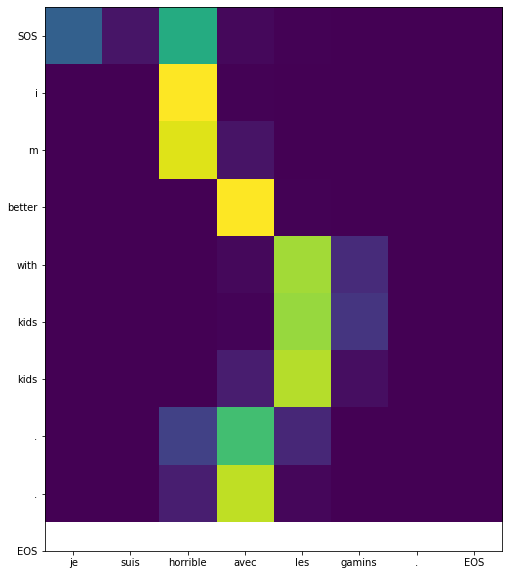

In [124]:
def generate_attention_matrix(x, y, lang1, lang2):
    encoder.eval()
    decoder.eval()
    x = x.view(-1, 1)
    input = encoder.embedding(x)
    x_len = torch.tensor([x.shape[0]])
    input = pack_padded_sequence(input, x_len)
    encoder_outputs, decoder_hidden = encoder(x, x_len) # last encoder hidden state becomes decoder hidden state
    y_pred = [english_lang.word2index['SOS']]
    decoder_input = torch.full((1, decoder_hidden.shape[1]), y_pred[-1])
    attention_weights = []
    while y_pred[-1]!=EOSToken: # 2 is the EOSToken
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
        attention_weights.append(list(decoder.attn_weights.squeeze().detach().numpy()))
        topv, topi = decoder_output.topk(1, dim=1)
        decoder_input = topi.transpose(0, 1)
        y_pred.append(topi.item())
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(attention_weights)
    x = [lang1.index2word[x[i, 0].item()] for i in range(len(x))]
    y_pred = [lang2.index2word[y_pred[i]] for i in range(len(y_pred))]
    ax.set_xticks(range(len(x)), labels=x)
    ax.set_yticks(range(len(y_pred)), labels=y_pred)
    
idx = random.randrange(len(dataset))
x, y = dataset[idx]
generate_attention_matrix(x, y, french_lang, english_lang)

# 3. Transformers
Resources that helped me: \
http://nlp.seas.harvard.edu/2018/04/01/attention.html really really helpful \
https://arxiv.org/pdf/1706.03762.pdf orginial paper \
https://lilianweng.github.io/posts/2020-04-07-the-transformer-family/#transformer easily digestible explanation of core concepts

## Part 1: Layers 

In [61]:
class MultiHeadAttentionSublayer(nn.Module):
    def __init__(self, d_model, heads=8):
        super(MultiHeadAttentionSublayer, self).__init__()
        assert(d_model % heads == 0)
        # assume d_k = d_v
        d_k = d_model // heads
        self.heads = nn.ModuleList([SingleHeadAttention(d_model, d_k) for i in range(heads)])
        self.w_o = nn.Linear(d_model, d_model)
    def forward(self, q, k, v, mask):
        x = torch.cat([self.heads[i](q, k, v, mask) for i in range(len(self.heads))], dim=-1)
        x = self.w_o(x)
        return x

class SingleHeadAttention(nn.Module):
    def __init__(self, d_model, d_k):
        super(SingleHeadAttention, self).__init__()
        self.wq = nn.Linear(d_model, d_k)
        self.wk = nn.Linear(d_model, d_k)
        self.wv = nn.Linear(d_model, d_k)
            
    def forward(self, q, k, v, mask=None): 
        # mask tells you which values each query can attend to. It is binary: 1 for can use and 0 for not allowed.
        # masking out padding and for the decoder self attention layer, subsequent words 
        # apply weights to get the q, k, v of this head
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) 
        d_k = q.size(-1)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k) 
        # for scores, each row contains the weights for the ith query, column is the key
        # (*, L, L)
        # a_i,j = weight for ith query and jth key
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
            
        weights = F.softmax(scores, dim = -1) # scale across all keys 
        return torch.matmul(weights, v) # combining the rows of v using the rows in weights
    
class FeedForwardSublayer(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super(FeedForwardSublayer, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        return self.w_2(F.relu(self.w_1(x)))
    
class SublayerConnection(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, sublayer_out):
        return self.norm(x + self.dropout(sublayer_out))  

class LayerNorm(nn.Module): # https://arxiv.org/pdf/1607.06450.pdf
    def __init__(self, d_model):
        super(LayerNorm, self).__init__()
        self.g = nn.Parameter(torch.ones(d_model))
        self.b = nn.Parameter(torch.zeros(d_model))
    def forward(self, x):
        # compute mean and std for layer
        mean = torch.mean(x, dim=-1, keepdim=True).to(x.device)
        std = torch.std(x, dim=-1, keepdim=True).to(x.device)
        # normalize
        return ((self.g * (x - mean)) / (std + 1e-8)) + self.b

## Part 2: Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, d_model, N):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model) for i in range(N)])
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttentionSublayer(d_model)
        self.feed = FeedForwardSublayer(d_model)
        self.conn1 = SublayerConnection(d_model)
        self.conn2 = SublayerConnection(d_model)
    def forward(self, x, mask):
        sublayer_out = self.attn(x, x, x, mask)
        x = self.conn1(x, sublayer_out)
        sublayer_out = self.feed(x)
        x = self.conn2(x, sublayer_out)
        return x
        

## Part 3: Decoder

In [6]:
class Decoder(nn.Module):
    def __init__(self, d_model, N):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model) for i in range(N)])
    def forward(self, x, encoder_final, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_final, src_mask, tgt_mask)
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttentionSublayer(d_model)
        self.encoder_attn = MultiHeadAttentionSublayer(d_model)
        self.feed = FeedForwardSublayer(d_model)
        self.conn1 = SublayerConnection(d_model)
        self.conn2 = SublayerConnection(d_model)
    def forward(self, x, encoder_final, src_mask, tgt_mask):
        sublayer_out = self.self_attn(x, x, x, tgt_mask)
        sublayer_out = self.encoder_attn(x, encoder_final, encoder_final, src_mask)
        x = self.conn1(x, sublayer_out)
        sublayer_out = self.feed(x)
        x = self.conn2(x, sublayer_out)
        return x

## Part 4: Embeddings

In [66]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, maxlen=500):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(maxlen, d_model)
        time_steps = torch.arange(0, maxlen)
        for i in range(d_model):
            if (i % 2 == 0):
                self.encoding[:, i] = torch.sin(time_steps / torch.float_power(torch.tensor(1000), i/d_model).item())
            else:
                self.encoding[:, i] = torch.cos(time_steps / torch.float_power(torch.tensor(1000), (i-1)/d_model).item())
        self.encoding = self.encoding.unsqueeze(0)
    def forward(self, x):
        return x + torch.autograd.Variable(self.encoding[:, :x.size(1), :], requires_grad=False).to(x.device)

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.out = nn.Linear(d_model, vocab)
    def forward(self, x):
        return F.log_softmax(self.out(x), dim=-1) # KL-Divergence takes the log of the probabilities

## Part 5: Full Model

In [68]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=512, N=6, dropout=0.1):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.embed_src = Embeddings(d_model, src_vocab)
        self.positional = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(p=dropout)
        self.encoder = Encoder(d_model, N)
        self.embed_tgt = Embeddings(d_model, tgt_vocab)
        self.decoder = Decoder(d_model, N)
        self.generator = Generator(d_model, tgt_vocab)
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    def forward(self, src, tgt, src_mask, tgt_mask): # src_mask and tgt_mask remove 
        x = self.embed_src(src)
        x = self.positional(x)
        x = self.dropout(x)
        encoder_final = self.encoder(x, src_mask)
        x = self.embed_tgt(tgt)
        x = self.positional(x)
        x = self.dropout(x)
        decoder_final = self.decoder(x, encoder_final, src_mask, tgt_mask)
        return decoder_final

## Part 6: Testing Random Things

In [14]:
def subsequent_mask(L):
    mask = np.tril(np.ones((1, L, L)), k=0) # lower traingle is all filled -> ith query can use values v_j where j is in 0..i 
    return torch.from_numpy(mask)

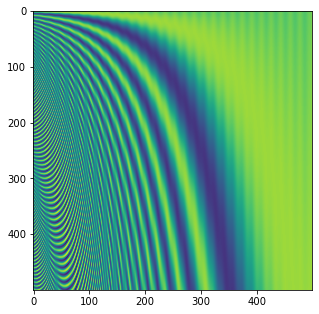

In [15]:
x = PositionalEncoding(500)
fig, ax = plt.subplots(figsize=(5, 15))
ax.imshow(x.encoding.squeeze().numpy())

## Part 7: Copy Task
portions here can be directly attributed to http://nlp.seas.harvard.edu/2018/04/01/attention.html

In [9]:
# Note: This part is very important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, d_model, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.d_model = d_model
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.d_model ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.d_model, 2, 4000,
    torch.optim.Adam(model.parameters(),
        lr=0, betas=(0.9, 0.98), eps=1e-9))

In [10]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

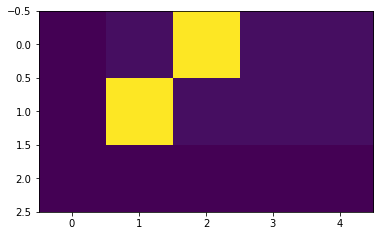

In [11]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.1) # 5 is the vocab size -- includes the padding token
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [1, 0, 0, 0, 0]]) # sentence length x vocab size
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

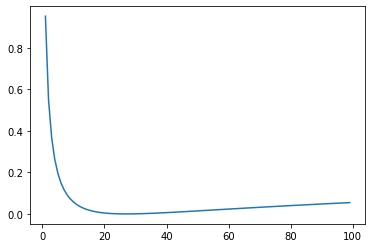

In [12]:
# Label smoothing starts to penalize the model 
# if it gets very confident about a given choice
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data.item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

In [16]:
def loss_backprop(generator, criterion, out, targets, normalize, bp=True):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.data.item()
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    if bp:
        out_grad = torch.stack(out_grad, dim=1)
        out.backward(gradient=out_grad)
    return total

In [41]:
# data generation for the copy task 

def make_std_mask(src, tgt, pad):
    """
    Create a mask to hide padding and future words.
    
    src and tgt are B x L tensors where B is the batch size and L is the sentence length 
    """
    
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

class Batch:
    "Batch object."
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
        
def data_gen(V, batch, nbatches): # batch = batch size
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10))) # 0 is padding, so only use 1-V
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

In [70]:
def train_epoch(train_iter, model, criterion, opt):
    "Standard Training and Logging Function"
    model.train()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        src = src.to(device)
        trg = trg.to(device)
        src_mask = src_mask.to(device)
        trg_mask = trg_mask.to(device)
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, 
                             out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)
            
def valid_epoch(valid_iter, model, criterion):
    "Standard validation function"
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    total = 0
    total_tokens = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        src = src.to(device)
        trg = trg.to(device)
        src_mask = src_mask.to(device)
        trg_mask = trg_mask.to(device)
        out = model.forward(src, trg[:, :-1], 
                            src_mask, trg_mask[:, :-1, :-1])
        total += loss_backprop(model.generator, criterion, out, trg[:, 1:], 
                             batch.ntokens, bp=False) * batch.ntokens
        total_tokens += batch.ntokens
    return total / total_tokens

In [71]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
example_model = Transformer(V, V, N=2)
model_opt = get_std_opt(model)
for epoch in range(2):
    train_epoch(data_gen(V, 30, 20), example_model, criterion, model_opt)
    print("Validation Loss:", valid_epoch(data_gen(V, 30, 5), example_model, criterion).item())

1 3.0705456733703613 6.987712429686844e-07
11 3.126532793045044 4.192627457812107e-06
Validation Loss: 3.150235652923584
1 2.9469976127147675 7.686483672655528e-06
11 3.0570517778396606 1.118033988749895e-05
Validation Loss: 3.090402841567993


In [56]:
example_model.positional.parameters()

<generator object Module.parameters at 0x7fa000146820>

In [128]:
def evaluate(batch, model, criterion):
    print(batch.trg[0, :])
    model.eval()
    src, trg, src_mask, trg_mask = \
        batch.src, batch.trg, batch.src_mask, batch.trg_mask
    out = model.forward(src, trg[:, :-1], 
                        src_mask, trg_mask[:, :-1, :-1])
    print(out.shape, batch.trg.shape)
    outs = []
    for i in range(out.size(1)): # in this case, 9, because we have length 10 sentences and 1 word is the "SOS token"
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = model.generator(out_column) # log probabilites for each word being the ith output word
        outs.append(gen)
    print(torch.vstack(outs)[0, :])

x = [batch for batch in data_gen(11, 30, 1)]
evaluate(x[0], model, criterion)

tensor([7, 9, 7, 9, 7, 9, 1, 5, 8, 5])
torch.Size([30, 9, 512]) torch.Size([30, 10])
tensor([-8.9079, -2.7261, -3.7012, -2.5811, -3.9274, -1.7221, -3.2705, -1.7068,
        -2.6371, -1.1161, -4.0702], grad_fn=<SliceBackward0>)


## Part 8: A Real Task

In [22]:
# The SOS Token is now the first token of all y_true 
# and the EOS Token is not a part of x 
# should still use the other version of the code above for the RNN models

def convert_to_tensor(lang, sentence, input_lang):
    sentence = [lang.word2index[word] for word in sentence.split(' ')]
    if input_lang is False:
        sentence.insert(0, lang.word2index["SOS"])
        sentence.append(lang.word2index["EOS"])
    return torch.tensor(sentence, dtype=torch.long)


class SentenceDataset(Dataset):
    def __init__(self, lang1, lang2, pairs):
        self.lang1 = lang1
        self.lang2 = lang2
        self.pairs = []
        for i in range(len(pairs)):
            s1, s2 = pairs[i]
            self.pairs.append([convert_to_tensor(lang1, s1, True), convert_to_tensor(lang2, s2, False)])
    def __getitem__(self, idx):
        return self.pairs[idx][0], self.pairs[idx][1]
    def __len__(self):
        return len(self.pairs)

def pad_collate(batch):
    x, y = zip(*batch)
    x_lens = torch.tensor([len(i) for i in x])
    y_lens = torch.tensor([len(i) for i in y])
    x_pad = pad_sequence(x, padding_value=0)
    y_pad = pad_sequence(y, padding_value=0)
    
    # sort 
    x_lens, idx = x_lens.sort(0, descending=True)
    y_lens = y_lens[idx]
    x_pad = x_pad[:, idx]
    y_pad = y_pad[:, idx]
    
    return x_pad, y_pad, x_lens, y_lens

dataset = SentenceDataset(french_lang, english_lang, pairs)
print(f"{len(dataset)} total examples")
train_set_size = int(len(dataset) * 0.9)
train_set = torch.utils.data.Subset(dataset, range(0, train_set_size))
valid_set = torch.utils.data.Subset(dataset, range(train_set_size, len(dataset)))
train_set, valid_set = torch.utils.data.random_split(dataset, [train_set_size, len(dataset) - train_set_size])
print(f"{len(train_set)} training examples and {len(valid_set)} validation examples")
train_data_loader = DataLoader(train_set, batch_size=32, shuffle=False, collate_fn=pad_collate)
val_data_loader = DataLoader(valid_set, batch_size=32, shuffle=False, collate_fn=pad_collate)

10599 total examples
9539 training examples and 1060 validation examples


In [74]:
def data_gen(data_loader):
    for src, tgt, src_lens, tgt_lens in data_loader:
        src = src.transpose(0, 1)
        tgt = tgt.transpose(0, 1)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())       

In [72]:
src_vocab = french_lang.n_words + 1
tgt_vocab = english_lang.n_words + 1
criterion = LabelSmoothing(size=tgt_vocab, padding_idx=0, smoothing=0.1)
model = Transformer(src_vocab, tgt_vocab)
model_opt = NoamOpt(model.d_model, 2, 4000, torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9))

In [75]:
for epoch in range(20):
    train_epoch(data_gen(train_data_loader), model, criterion, model_opt)
    print("Validation Loss:", valid_epoch(data_gen(val_data_loader), model, criterion).item())

1 6.382612235844135 6.987712429686844e-07
11 5.880567751824856 4.192627457812107e-06
21 5.2668477185070515 7.686483672655528e-06
31 4.719393603503704 1.118033988749895e-05
41 4.482644026167691 1.4674196102342371e-05
51 4.266209810972214 1.8168052317185794e-05
61 4.340397300198674 2.1661908532029216e-05
71 3.9542711172252893 2.515576474687264e-05
81 3.9745383160188794 2.8649620961716057e-05
91 3.6233432944864035 3.214347717655948e-05
101 3.552631534577813 3.56373333914029e-05
111 3.2143116299412213 3.913118960624633e-05
121 2.8324348997412017 4.262504582108975e-05
131 2.7684065499561257 4.611890203593317e-05
141 2.637264327131561 4.961275825077659e-05
151 2.4914106815704145 5.310661446562001e-05
161 2.4582338652107865 5.660047068046343e-05
171 2.1866989573900355 6.0094326895306855e-05
181 2.410786448941508 6.358818311015028e-05
191 2.2005872426962014 6.70820393249937e-05
201 2.3148670830996707 7.057589553983712e-05
211 2.1674356116272975 7.406975175468054e-05
221 2.1432551969919587 7.75

KeyboardInterrupt: 

In [37]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [77]:
def convert_to_lang(sentence, lang):
    text = [lang.index2word[sentence[i]] for i in range(len(sentence))]
    return ' '.join(text)

def eval_on_sentence(model, x):
    model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    x = x.unsqueeze(0)
    y_pred = [english_lang.word2index['SOS']]
    count = 0
    while y_pred[-1]!=2 and count < 20: # 2 is the EOSToken
        src = x
        tgt = torch.tensor(y_pred).unsqueeze(0)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        src = src.to(device)
        tgt = tgt.to(device)
        src_mask = src_mask.to(device)
        tgt_mask = tgt_mask.to(device)
        out = model(src, tgt, src_mask, tgt_mask) # 1 x L x 512
        out = model.generator(out) # 1 x L x dict_size
        out = torch.exp(out)
        topv, topi = out.topk(1, dim=-1)
        #print(topi, topi.shape, y_pred)
        y_pred.append(topi[0, -1, 0].item())
        count+=1
        
    return y_pred
        
def eval_on_sentences(model, dataset, lang1, lang2, num=10):
    for i in range(num):
        idx = random.randrange(len(dataset))
        x, y = dataset[idx]
        y_pred = eval_on_sentence(model, x)
        print(convert_to_lang(x.numpy(), lang1))
        print(convert_to_lang(y.numpy(), lang2))
        print(convert_to_lang(y_pred, lang2))
        print()
              
eval_on_sentences(model, dataset, french_lang, english_lang, num=10)

elles sont toutes en vacances .
SOS they re all on vacation . EOS
SOS they re all on vacation . EOS

c est un gentleman .
SOS he is a gentleman . EOS
SOS he s a famous singer . EOS

c est vous l instituteur .
SOS you re the teacher . EOS
SOS you re the teacher . EOS

vous etes tres perspicace .
SOS you re very perceptive . EOS
SOS you re very sensitive to us . EOS

elle est occupee a preparer le voyage .
SOS she is busy preparing for the trip . EOS
SOS she s busy preparing for the trip . EOS

vous etes trop confiant .
SOS you re too trusting . EOS
SOS you re too skinny . EOS

nous sommes tres reconnaissantes .
SOS we re very grateful . EOS
SOS we re anxious . EOS

je suis desolee . j ai oublie .
SOS i m sorry . i forgot . EOS
SOS i m sorry for the news . EOS

je crains que tom ne se perde .
SOS i m afraid tom will get lost . EOS
SOS i m just married as tom . EOS

il est probable qu il gagne le jeu .
SOS he is likely to win the game . EOS
SOS he s likely to win the game . EOS

